# Parquet - or How even the data engineers can become super heroes 
Today, digital data accounts for 3 to 4% of global greenhouse gas emissions.

Big data is no stranger to this…

4% is the same share of emissions as all the countries in Sub-Saharan Africa.

Let's see how, with just one line of code and 1-2 brain calories burned, we can substantially reduce this.

Parquet is now always referenced as a columnar format.
In every documentation or guide, it has become the standard for structured data.

The main advice we find is that for big data or analytics, Parquet is the king format.
It encourages us to use it to save on size and speed up reading.

But let's see how a slight understanding of the format could help us gain even more than what's promised in terms of compression and space savings.

Of course, we'll lose a bit in processing time. But for data that is frequently accessed, we'll save a lot of bandwidth.
We can think of it as an overhead in writing that pays off well!

We will quickly skim through **1 - Columnar vs Row-based Storage** to cover the basics of data storage.
Then, in **2 - Parquet Encoding Secrets** that are not so secret (you just had to read the docs), we'll dive into the heart of the matter.


## 1 - Columnar vs Row-based **Storage**

First things first, we must understand that there are different storage types in the structured data realm.

Each has its own usage that can be summarized as follow : 

**- Row-Based Storage** : Best for OLTP (Online Transaction Processing) systems where quick access to individual records is needed.

**- Columnar Storage**  : Ideal for OLAP (Online Analytical Processing) systems where large-scale data analysis is performed, and only a subset of columns is typically queried.

<img src="./metadata/storage_types.png" alt="Image Description" width="400"/>

**CSV**,**Json** is an example of row-based storage.

**PARQUET** or **ORC** are commonly known as being columnar ....  but ..



### WHY is PARQUET SPECIAL ? 
**PARQUET** is an hybrid TYPE. combining columnar and row-based storage

where data is divided into [Row groups x Columns] 

 --> Row Group 1

 ---> Column 0

 ...

 ---> Column x

 --> Row Group 2 
 
 ....

Each ROW GROUP stores its own metadata about the columns in order to use them later.   
 Indeed for each column of a row group there would be a *min/max/count* metadata  that will be used in **predicate pushdowns** during parquet reads.

<img src="./metadata/parquet_row_group.png" alt="Image Description" width="400"/>

## 2. Parquet Secrets

As Data is stored in columns, in Parquet it can be easily encoded before writing it.

### 2.a automatic compression
Resulting in a big compression of data. To illustrate that quickly; let us generate a dataset an store it as csv and parquet.



In [224]:
### Step 1: Generate a Sample Dataset
import uuid
import pandas as pd
import numpy as np
import os
 
dataset_size = 500_000
# Function to generate a list of GUIDs
def generate_guids(size):
    return [str(uuid.uuid4()) for _ in range(size)]

# Create a sample DataFrame with some repetitive data
data = {
    'id': np.random.randint(0, 202020, size=dataset_size),
    'guid': generate_guids(dataset_size),
    'category': np.random.choice(['A', 'B', 'C', 'D'], size=dataset_size),
    'country': np.random.choice(['United States', 'France', 'The Netherlands', 'Germany'], size=dataset_size),
    'value': np.random.randn(dataset_size),
}

#     'id': np.arange(0, dataset_size,step=1)
df = pd.DataFrame(data)


### Size comparison between CSV and Parquet

23.925024032592773


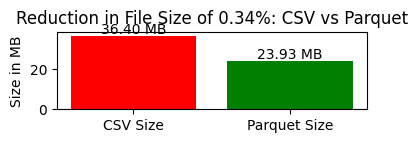

In [226]:
import matplotlib.pyplot as plt

df = df.sample(frac=1).reset_index(drop=True)
# Save the DataFrame to CSV and Parquet formats
df.to_csv('sample_data.csv', index=False)
df.to_parquet('sample_data.parquet')

csv_size = os.path.getsize('sample_data.csv') / (1024 * 1024)  # Convert to MB
parquet_size = os.path.getsize('sample_data.parquet') / (1024 * 1024)  # Convert to MB 
parquet_size_unsampled = os.path.getsize('sample_data_unsampled.parquet') / (1024 * 1024)  # Convert to MB 

print(parquet_size_unsampled)
# Labels and sizes
labels = ['CSV Size', 'Parquet Size']
sizes = [csv_size, parquet_size]

# Plotting the bar chart
plt.figure(figsize=(4,1))
plt.bar(labels, sizes, color=['red', 'green'])
plt.title(f'Reduction in File Size of {(1 - parquet_size/csv_size):.2f}%: CSV vs Parquet')
plt.ylabel('Size in MB')

# Display the size values on top of the bars
for i, size in enumerate(sizes):
    plt.text(i, size + 1, f'{size:.2f} MB', ha='center', fontsize=10)

plt.show()

In [227]:
df.head(10)

,id,guid,category,country,value
0,75331,a5027b76-451c-4464-a9f3-819fed60584e,A,United States,0.294197
1,193376,3e98ae04-db22-477e-a745-677e91a54109,C,Germany,-0.594720
2,77024,0ad947f9-85ce-4b79-8302-fa6cb266bc92,A,United States,0.476722
3,164261,b0d5f888-1b13-4bf4-ba42-2897cc23c3ac,B,France,0.267367
4,36248,afc1ebc2-bb1e-4e45-be0e-6978bba7ce34,B,United States,0.101652
5,170209,533f894e-089e-45b4-ae49-57db86a1aa76,C,United States,1.144634
6,136103,ddfc0e49-d366-43a6-8401-98809a153d4f,D,The Netherlands,1.158936
7,12743,c996bfdd-139a-42a4-a4a5-42aca1927861,A,Germany,-2.047110
8,159368,8684e14e-9f83-4707-9c6a-ea9804a3479f,C,France,-1.832821
9,178900,67b19afe-3307-49d2-adc5-1fd470a4ec31,D,France,-0.001978



### before writing df to disk, each column is encoded with the best technique for its type.

#### Example 1  :  Column Country
##### Step I  - **country** is encoded as a dictionnary of countries.
##### Step II - RLE encoding + Bit packing is then applied to maximes encoding and compression.

<img src="./metadata/RLE_bit_packing.png" alt="Image Description" width="600"/>

## Important - What does this mean ? 

if we order by Country before writing, we would have a sorted sequence wich could lead to a massive packing 

if we take the example above we would have this bit packing: 
**[0,2] [1,2] [2,1] [3,3]** - zero appears 2 times, 1 appears 2 times etc ...

#### For 1.000 rows, we could encode them in a very limited number of bytes !!!!!
for example, it would be encoded in **[0,650] [1,75] [2,150] [3,125]** resulting in a 99% reduction size in that specific case



### Example 2 : ID column and Delta byte Packing

##### Step I - Calculate delta between each row for column ID. let's say sorted and incremented by 1.

which would lead to a 1, 1, 1, 1, 1 ..... 1 

##### Step II - take minimum delta and calculate relative delta.

The minimum delta is 1 and the relative deltas to it becomes:

0, 0, 0, 0

The final encoded data is:

header: 8 (block size), 1 (miniblock count), 5 (value count), 1 (first value)

##### we end up with approx no data at all in comparison to an id column with millions of values if stored in plain text.

<img src="./metadata/delta_encoding.png" alt="Image Description" width="400"/>

In [212]:
# List to store parquet file sizes after sorting by each column
parquet_sizes = {}

# Iterate over each column, sort, save as Parquet, and record the file size
for column in df.columns:
    df_sorted = df.sort_values(by=[column])
    parquet_file_name = f'sample_data_sorted_{column}.parquet'
    df_sorted.to_parquet(parquet_file_name, compression='snappy')
    
    # Get the file size in MB
    parquet_size_sorted = os.path.getsize(parquet_file_name) / (1024 * 1024)
    parquet_sizes[column] = parquet_size_sorted
    print(f"Parquet File Size (sorted by {column}): {parquet_size_sorted:.2f} MB")

Parquet File Size (sorted by id): 24.00 MB
Parquet File Size (sorted by guid): 23.42 MB
Parquet File Size (sorted by category): 24.08 MB
Parquet File Size (sorted by country): 24.07 MB
Parquet File Size (sorted by value): 24.60 MB


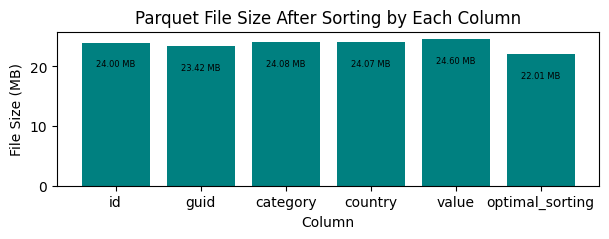

In [215]:

parquet_sizes['optimal_sorting']=parquet_size
# Plot the results
plt.figure(figsize=(7, 2))
plt.bar(parquet_sizes.keys(), parquet_sizes.values(), color='teal')
plt.title('Parquet File Size After Sorting by Each Column')
plt.xlabel('Column')
plt.ylabel('File Size (MB)')

# Display the file size values on top of the bars
for i, (col, size) in enumerate(parquet_sizes.items()):
    plt.text(i, size - 4 , f'{size:.2f} MB', ha='center', fontsize=6)

plt.show()

In [177]:
df_sorted_id = df.sort_values(by=['country','category','value'])
df_sorted_id.to_parquet('sample_data_sorted_id.parquet', compression='snappy')

parquet_size_sorted_id = os.path.getsize('sample_data_sorted_id.parquet') / (1024 * 1024)  # Convert to MB


print(f"Parquet File Size: {parquet_size_sorted_id:.2f} MB")


Parquet File Size: 26.49 MB


##### Go the extra mile : 

We can inspect the encoding for each column in each row group as follow : 


In [170]:
import pyarrow.parquet as pq

# Load the Parquet file
parquet_file = pq.ParquetFile('sample_data.parquet')

# Print out the metadata
metadata = parquet_file.metadata
print(metadata)

# To see more detailed information, including encoding for each column:
for i in range(parquet_file.num_row_groups):
    row_group = parquet_file.metadata.row_group(i)
    for j in range(row_group.num_columns):
        column = row_group.column(j)
        print(f"Column: {column.path_in_schema}")
        print(f"- Encodings : {column.encodings}")
        print(f" - Compression: {column.compression}")
        print(f" - Total Size: {column.total_compressed_size} bytes")
        print(f" - Uncompressed Size: {column.total_uncompressed_size} bytes")
        print(f" - Num Values: {column.num_values}")


  created_by: parquet-cpp-arrow version 17.0.0
  num_columns: 5
  num_rows: 500000
  num_row_groups: 1
  format_version: 2.6
  serialized_size: 3305
Column: id
- Encodings : ('PLAIN', 'RLE', 'RLE_DICTIONARY')
 - Compression: SNAPPY
 - Total Size: 2676199 bytes
 - Uncompressed Size: 4176283 bytes
 - Num Values: 500000
Column: guid
- Encodings : ('PLAIN', 'RLE', 'RLE_DICTIONARY')
 - Compression: SNAPPY
 - Total Size: 18102433 bytes
 - Uncompressed Size: 20052121 bytes
 - Num Values: 500000
Column: category
- Encodings : ('PLAIN', 'RLE', 'RLE_DICTIONARY')
 - Compression: SNAPPY
 - Total Size: 126080 bytes
 - Uncompressed Size: 126069 bytes
 - Num Values: 500000
Column: country
- Encodings : ('PLAIN', 'RLE', 'RLE_DICTIONARY')
 - Compression: SNAPPY
 - Total Size: 126130 bytes
 - Uncompressed Size: 126119 bytes
 - Num Values: 500000
Column: value
- Encodings : ('PLAIN', 'RLE', 'RLE_DICTIONARY')
 - Compression: SNAPPY
 - Total Size: 4279334 bytes
 - Uncompressed Size: 4279116 bytes
 - Num Va

sources : 

https://parquet.apache.org/docs/file-format/data-pages/encodings/  
https://www.databricks.com/fr/glossary/what-is-parquet


